# ***This notebook uses to extract sign language hand landmarks and add the landmarks to the image.Google Mediapipe Hand landmark recognition model is used for this purpose.***

In [ ]:
!pip install mediapipe
!pip install  cvzone

# Hand landmarks detection

The MediaPipe Hand Landmarker task lets you detect the landmarks of the hands in an image. You can use this task to locate key points of hands and render visual effects on them. This task operates on image data with a machine learning (ML) model as static data or a continuous stream and outputs hand landmarks in image coordinates, hand landmarks in world coordinates and handedness(left/right hand) of multiple detected hands.

https://ai.google.dev/edge/mediapipe/solutions/vision/hand_landmarker

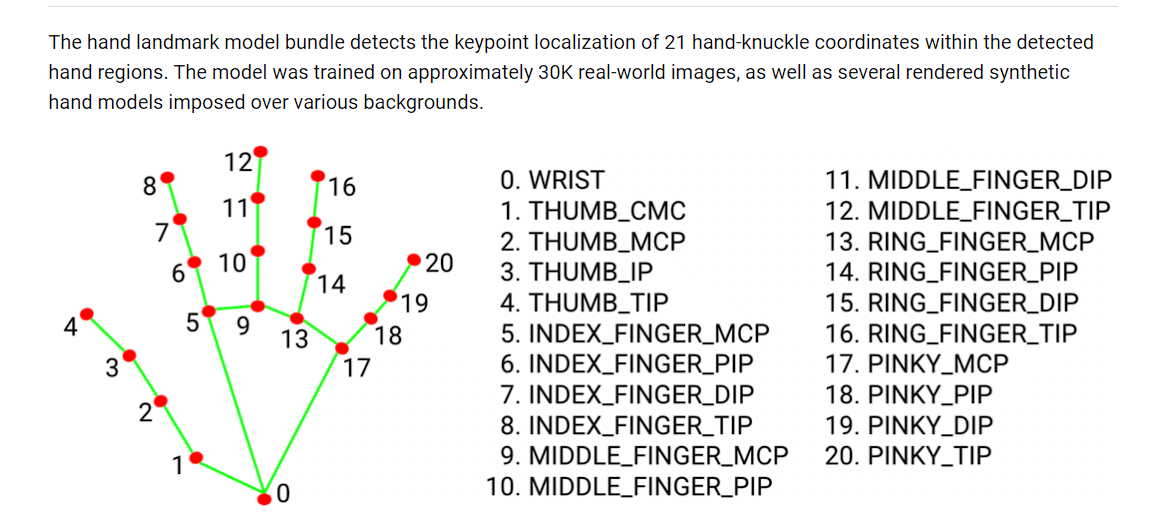

In [ ]:
import os
import pickle

import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Media pipeline test

In [ ]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

img = cv2.imread("/kaggle/input/american-sign-language-dataset/asl_dataset/d/hand1_d_bot_seg_3_cropped.jpeg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = hands.process(img_rgb)

print(results.multi_hand_landmarks)

for hand_landmark in results.multi_hand_landmarks:
  h, w, _ = img_rgb.shape
  print(h,w)


  print(hand_landmark.landmark)
    # Extract and print the coordinates of each landmark point
  for i, landmark in enumerate(hand_landmark.landmark):
      x, y, z = int(landmark.x * w), int(landmark.y * h), landmark.z
      print(f"Landmark {i}: (x: {x}, y: {y}, z: {z})")


  mp_drawing.draw_landmarks(
      img,#image
      hand_landmark, #model output
      mp_hands.HAND_CONNECTIONS,#hand connection
      mp_drawing_styles.get_default_hand_landmarks_style(),
      mp_drawing_styles.get_default_hand_connections_style())

plt.imshow(img)
plt.show()

## Croped the detected image 

In [ ]:
import cv2
import mediapipe as mp
#from google.colab.patches import cv2_imshow

# Initialize MediaPipe Hands and drawing utilities
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Initialize the Hands model
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

# Read an image
image_path = '/kaggle/input/american-sign-language-dataset/asl_dataset/d/hand1_d_bot_seg_3_cropped.jpeg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Process the image to detect hand landmarks
results = hands.process(image_rgb)
cutoff = 40
# Check if any hands are detected
if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
        # Get the landmarks
        landmarks = hand_landmarks.landmark
        #print(landmarks)
        h, w, _ = image.shape

        # Initialize bounding box coordinates
        min_x, min_y = w, h
        max_x, max_y = 0, 0

        # Iterate through landmarks to find the bounding box
        for landmark in landmarks:
            x, y = int(landmark.x * w), int(landmark.y * h)
            min_x, min_y = min(min_x, x), min(min_y, y)
            max_x, max_y = max(max_x, x), max(max_y, y)
        print(min_x,min_y,max_x,max_y)

        #Define X Y margine
        if min_x-cutoff < 0:
          minx=0
        else:
          minx=min_x-cutoff

        if min_y-cutoff < 0:
          miny=0
        else:
          miny=min_y-cutoff

        if max_x+cutoff > w:
          maxx=max_x
        else:
          maxx=max_x+cutoff

        if max_y+cutoff > h:
          maxy=max_y
        else:
          maxy=max_y+cutoff

        # Draw the bounding box
        cv2.rectangle(image, (minx, miny), (maxx, maxy), (0, 255, 0), 2)
        #cv2.imshow(image)
        plt.imshow(image)
        plt.title("Image before Cropped")
        plt.show()
        # Crop the image to the bounding box
        cropped_image = image[miny:maxy,minx:maxx]
        
        # Optional: Draw landmarks and connections
        mp_drawing.draw_landmarks(
            image, hand_landmarks, mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

print(results)# Display the output image with bounding box
#cv2.imshow(cropped_image)
plt.imshow(cropped_image)
plt.title("Image after Cropped")
plt.show()
#cv2.waitKey(0)
#cv2.destroyAllWindows()


# Sign Language hand landmark data Extraction

**Steps**
1. Detect the hand
2. Crop the hand area
    - cutoff=30
    - desired_size=(300,300,3)
3. Extracted the landmark use mediapipe
4. Save the landmark in the data frame
5. Save the copied image with landmark

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd

import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow
from PIL import Image


In [ ]:
def resize_with_padding(image, desired_size):
    # Load the image
    #image = cv2.imread(image_path)

    # Get the current dimensions
    h, w = image.shape[:2]

    # Calculate the aspect ratio
    aspect_ratio = w / h
    # Determine new dimensions keeping the aspect ratio
    if aspect_ratio > 1:  # width is greater than height
        new_w = desired_size[0]
        new_h = int(new_w / aspect_ratio)
    elif aspect_ratio == 1:
        new_w = desired_size[0]
        new_h = desired_size[0]
    else:  # height is greater than width
        new_h = desired_size[1]
        new_w = int(new_h * aspect_ratio)

    # Resize the image
    resized_image = cv2.resize(image, (new_w, new_h))

    # Calculate padding to make the image the desired size
    delta_w = desired_size[0] - new_w
    delta_h = desired_size[1] - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # Pad the image
    color = [0,0,0]  # Padding color (white)
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_image

## Saved the landmarks only-colab notebook

In [ ]:


# Initialize MediaPipe Hands and drawing utilities
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

cutoff=30 #crop cutoff limit
desired_size=(300,300,3) # resized size


#x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
#y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16,y17,y18,y19,y20=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]

#define x y storage location
x_lists = {}
y_lists = {}
z_lists = {}

for i in range(0, 21):
    x_lists[f'x{i}'] = []
    y_lists[f'y{i}'] = []
    z_lists[f'z{i}'] = []

label=[]
unwanted=["nothing"] #removed the unwanted image folders

# Initialize the Hands model
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.3)

root_folder='/kaggle/input/american-sign-language-dataset/asl_dataset'

for folder in os.listdir(root_folder):
    if folder not in unwanted:
      t=0 
      for file in os.listdir(os.path.join(root_folder,folder)):
        if t<=500: #limit the images
          #print(os.path.join(root_folder,folder,file))
          image_path=os.path.join(root_folder,folder,file)
          file_name=image_path.split("/")[-1]
          #print(file_name)


          # Read an image
          #image_path = '/content/hand1_b_left_seg_1_cropped.jpeg'
          image = cv2.imread(image_path)
          image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          #cv2_imshow(image_rgb)

          # Process the image to detect hand landmarks
          results = hands.process(image_rgb)

          # Check if any hands are detected
          if results.multi_hand_landmarks:
              for hand_landmarks in results.multi_hand_landmarks:
                  # Get the landmarks
                  landmarks = hand_landmarks.landmark
                  #print(landmarks)
                  h, w, _ = image_rgb.shape
                  #print(h,w)

                  for i, landmark in enumerate(landmarks):
                      x, y, z = int(landmark.x * w), int(landmark.y * h), landmark.z
                      #print(f"Landmark {i}: (x: {x}, y: {y}, z: {z})")

                  # Initialize bounding box coordinates
                  min_x, min_y = w, h
                  max_x, max_y = 0, 0

                  # Iterate through landmarks to find the bounding box
                  for landmark in landmarks:
                      x, y = int(landmark.x * w), int(landmark.y * h)
                      min_x, min_y = min(min_x, x), min(min_y, y)
                      max_x, max_y = max(max_x, x), max(max_y, y)



                  #Define X Y margine
                  if min_x-cutoff < 0:
                    minx=0
                  else:
                    minx=min_x-cutoff

                  if min_y-cutoff < 0:
                    miny=0
                  else:
                    miny=min_y-cutoff

                  if max_x+cutoff > w:
                    maxx=max_x
                  else:
                    maxx=max_x+cutoff

                  if max_y+cutoff > h:
                    maxy=max_y
                  else:
                    maxy=max_y+cutoff

                  # Draw the bounding box
                  #cv2.rectangle(image_rgb , (minx, miny), (maxx, maxy), (0, 255, 0), 2)
                  #cv2_imshow(image)

                  # Crop the image to the bounding box
                  cropped_image = image_rgb [miny:maxy,minx:maxx]
                  #cv2_imshow(cropped_image)

                  #resize image
                  resize_image=resize_with_padding(cropped_image, desired_size)

                  ##############GEt needa the land mark in image#######################

                  # Process the image to detect hand landmarks
                  results2 = hands.process(resize_image)

                  # Check if any hands are detected
                  if results2.multi_hand_landmarks:
                    #print("ok")
                    t += 1

                    for hand_landmarks2 in results2.multi_hand_landmarks:
                        # Get the landmarks
                        landmarks2 = hand_landmarks2.landmark
                        #print(landmarks)
                        h2, w2, _ = resize_image.shape
                        #print(h2,w2)

                        label.append(folder)

                        for i, landmark in enumerate(landmarks2):
                          if f'x{i}' in x_lists and f'y{i}' in y_lists:
                              x, y, z = int(landmark.x * w2), int(landmark.y * h2), int(landmark.z*100)
                              x_lists[f'x{i}'].append(x)
                              y_lists[f'y{i}'].append(y)
                              z_lists[f'z{i}'].append(z)

                              #print(f"Landmark {i}: (x: {x}, y: {y}, z: {z})")

                        # Optional: Draw landmarks and connections
                        mp_drawing.draw_landmarks(
                            resize_image,hand_landmarks2, mp_hands.HAND_CONNECTIONS,
                            mp_drawing_styles.get_default_hand_landmarks_style(),
                            mp_drawing_styles.get_default_hand_connections_style())

                        ####Save the proceed image######
                        # Define the parent folder and child folder
                        #parent_folder = "/kaggle/working/proceed_image2"# Set the output file directory
                        #child_folder = os.path.join(parent_folder,folder)

                        # Create the child folder if it doesn't exist
                        #os.makedirs(child_folder, exist_ok=True)

                        # Define the path to save the image
                       # image_path = os.path.join(child_folder, file_name)

                        # Save the image
                        #image_BGR = cv2.cvtColor(resize_image, cv2.COLOR_RGB2BGR)
                        #cv2.imwrite(image_path,image_BGR)

                        # Display the output image with bounding box
                        #plt.imshow(resize_image)
                        #plt.show()
                        
    series = pd.Series(label)
    count = series.value_counts()
    print("count of collected data :", count)


In [ ]:
print(z_lists["z2"])

In [ ]:
import pandas as pd

df_y=pd.DataFrame(y_lists)
df_x=pd.DataFrame(x_lists)
df_z=pd.DataFrame(z_lists)
df_label=pd.DataFrame(label)

df=pd.concat([df_x,df_y,df_z,df_label],axis=1)


In [ ]:
df.info()

In [ ]:
df.to_csv("aslamerican-sign-language-aplhabet-dataset.csv",index=False)

#### google drive data save location

In [ ]:
import subprocess

# Set environment variables and run the scp command
command = "scp -r /content/data_sign1_2.csv '/content/drive/MyDrive/Work_space/Project/sign_language/ML_dev/dataset/asl_dataset'"
process = subprocess.Popen(command, shell=True, env={"LC_ALL": "C.UTF-8", "LANG": "C.UTF-8"})
process.wait()

## Saved the Landmarks and images with landmarks

In [ ]:


# Initialize MediaPipe Hands and drawing utilities
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

cutoff=30 #crop cutoff limit
desired_size=(300,300,3) # resized size


#x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
#y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16,y17,y18,y19,y20=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]

#define x y storage location
x_lists = {}
y_lists = {}
z_lists = {}

for i in range(0, 21):
    x_lists[f'x{i}'] = []
    y_lists[f'y{i}'] = []
    z_lists[f'z{i}'] = []

label=[]
unwanted=["nothing"] #removed the unwanted image folders

# Initialize the Hands model
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.3)

root_folder='/kaggle/input/american-sign-language-dataset/asl_dataset'

for folder in os.listdir(root_folder):
    if folder not in unwanted:
      t=0 
      for file in os.listdir(os.path.join(root_folder,folder)):
        if t<=500: #limit the images
          #print(os.path.join(root_folder,folder,file))
          image_path=os.path.join(root_folder,folder,file)
          file_name=image_path.split("/")[-1]
          #print(file_name)


          # Read an image
          #image_path = '/content/hand1_b_left_seg_1_cropped.jpeg'
          image = cv2.imread(image_path)
          image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          #cv2_imshow(image_rgb)

          # Process the image to detect hand landmarks
          results = hands.process(image_rgb)

          # Check if any hands are detected
          if results.multi_hand_landmarks:
              for hand_landmarks in results.multi_hand_landmarks:
                  # Get the landmarks
                  landmarks = hand_landmarks.landmark
                  #print(landmarks)
                  h, w, _ = image_rgb.shape
                  #print(h,w)

                  for i, landmark in enumerate(landmarks):
                      x, y, z = int(landmark.x * w), int(landmark.y * h), landmark.z
                      #print(f"Landmark {i}: (x: {x}, y: {y}, z: {z})")

                  # Initialize bounding box coordinates
                  min_x, min_y = w, h
                  max_x, max_y = 0, 0

                  # Iterate through landmarks to find the bounding box
                  for landmark in landmarks:
                      x, y = int(landmark.x * w), int(landmark.y * h)
                      min_x, min_y = min(min_x, x), min(min_y, y)
                      max_x, max_y = max(max_x, x), max(max_y, y)



                  #Define X Y margine
                  if min_x-cutoff < 0:
                    minx=0
                  else:
                    minx=min_x-cutoff

                  if min_y-cutoff < 0:
                    miny=0
                  else:
                    miny=min_y-cutoff

                  if max_x+cutoff > w:
                    maxx=max_x
                  else:
                    maxx=max_x+cutoff

                  if max_y+cutoff > h:
                    maxy=max_y
                  else:
                    maxy=max_y+cutoff

                  # Draw the bounding box
                  #cv2.rectangle(image_rgb , (minx, miny), (maxx, maxy), (0, 255, 0), 2)
                  #cv2_imshow(image)

                  # Crop the image to the bounding box
                  cropped_image = image_rgb [miny:maxy,minx:maxx]
                  #cv2_imshow(cropped_image)

                  #resize image
                  resize_image=resize_with_padding(cropped_image, desired_size)

                  ##############GEt needa the land mark in image#######################

                  # Process the image to detect hand landmarks
                  results2 = hands.process(resize_image)

                  # Check if any hands are detected
                  if results2.multi_hand_landmarks:
                    #print("ok")
                    t += 1

                    for hand_landmarks2 in results2.multi_hand_landmarks:
                        # Get the landmarks
                        landmarks2 = hand_landmarks2.landmark
                        #print(landmarks)
                        h2, w2, _ = resize_image.shape
                        #print(h2,w2)

                        label.append(folder.upper())

                        for i, landmark in enumerate(landmarks2):
                          if f'x{i}' in x_lists and f'y{i}' in y_lists:
                              x, y, z = int(landmark.x * w2), int(landmark.y * h2), int(landmark.z*100)
                              x_lists[f'x{i}'].append(x)
                              y_lists[f'y{i}'].append(y)
                              z_lists[f'z{i}'].append(z)

                              #print(f"Landmark {i}: (x: {x}, y: {y}, z: {z})")

                        # Optional: Draw landmarks and connections
                        mp_drawing.draw_landmarks(
                            resize_image,hand_landmarks2, mp_hands.HAND_CONNECTIONS,
                            mp_drawing_styles.get_default_hand_landmarks_style(),
                            mp_drawing_styles.get_default_hand_connections_style())

                        ####Save the proceed image######
                        # Define the parent folder and child folder
                        parent_folder = "/kaggle/working/proceed_image1"# Set the output file directory
                        child_folder = os.path.join(parent_folder,folder)

                        # Create the child folder if it doesn't exist
                        os.makedirs(child_folder, exist_ok=True)

                        # Define the path to save the image
                        image_path = os.path.join(child_folder, file_name)

                        # Save the image
                        image_BGR = cv2.cvtColor(resize_image, cv2.COLOR_RGB2BGR)
                        cv2.imwrite(image_path,image_BGR)

                        # Display the output image with bounding box
                        plt.imshow(resize_image)
                        #plt.show()
                        
    series = pd.Series(label)
    count = series.value_counts()
    print("count of collected data :", count)


In [ ]:
#label=[i.upper() for i in label]
print(label)

In [ ]:
import zipfile
import os

# Define the directory to zip
directory = '/kaggle/working/proceed_image1'

# Name for the zip file
zip_filename = '/kaggle/working/american-sign-language_TEST.zip'

# Initialize Zip file object
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    # Walk through all the files and folders in the directory
    for foldername, subfolders, filenames in os.walk(directory):
        for filename in filenames:
            # Add each file to the zip
            zipf.write(os.path.join(foldername, filename), 
                       os.path.relpath(os.path.join(foldername, filename), 
                                       directory), 
                       compress_type = zipfile.ZIP_DEFLATED)

In [ ]:
import pandas as pd

df_y=pd.DataFrame(y_lists)
df_x=pd.DataFrame(x_lists)
df_z=pd.DataFrame(z_lists)
df_label=pd.DataFrame(label)

df=pd.concat([df_x,df_y,df_z,df_label],axis=1)

In [ ]:
df.info()

In [ ]:
df.to_csv("american-sign-language_TEST.csv",index=False)